In [1]:
#import pymat2
import os
import pandas as pd
from osgeo import gdal
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import matplotlib.gridspec as gridspec
#import matplotlib.pyplot as pl
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats.distributions as dist
#import libtfr

import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import sys, os, re
from scipy import stats

from __future__ import division
from osgeo import gdal
import numpy as np
import scipy.signal
import os
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
import random
import os
from osgeo import gdal
import scipy.signal
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

%matplotlib inline

C:\Python27x86\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The matplotlib.mpl module was deprecated in version 1.3. Use `import matplotlib as mpl` instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def listall(RootFolder, wildcard=''):
    lists = [os.path.join(root, name)    
                 for root, dirs, files in os.walk(RootFolder)
                   for name in files
                   if wildcard in name
                     if name.endswith('.tif')]
    return lists

def getvalues(rootpath, pc, pr, wildcard=''):
    
    li = []
    da = []
    i = 0
    
    #path = r'D:\Data\GPCP_30acc_AnnualAcc'
    test = listall(rootpath, wildcard)
    #test = test[0:-46]
    #print (len(test))
    #print (test[0])
    for t in test:    
        raster = gdal.Open(t, gdal.GA_ReadOnly)
        nameRas = raster.GetDescription()[-11:-4]
        date = datetime.datetime(int(nameRas[0:4]), 1, 1) + datetime.timedelta(int(nameRas[4:9]) - 1) # replaced "int(nameRas[0:4])" with "2010" first year then add doy
        # print date
        da.append(date)
    
        band = raster.GetRasterBand(1)
        array = band.ReadAsArray()    
        
        # print array[879,4142] # Grassland pixel
        try:
            li.append(array[pr, pc])
        except:
            li.append(np.nan)
        
        array = None
        band = None
        raster = None
        #print (str(i))
        i = i + 1
        
    signal = pd.Series(data = li, index = da)
    return signal

In [3]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)
        
def mtem(x, y):
    """
    multitaper estimation method
    input:
    x  first time series
    y  second time series

    output:
    fkx  power spectral density x
    fky  power spectral density y
    cxy  cross-spectral density xy
    coh  coherence
    ph  phase between xy at input freq
    
    """
    print ('x size', x.shape)
    print ('y size', y.shape)
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([x,y]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fkx = pcsd_est.diagonal().T[0]
    fky = pcsd_est.diagonal().T[1]
    cxy = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cxy)
    
    # calculate coherence using csd and psd
    coh = np.abs(cxy)**2 / (fkx * fky)   
    
    return f, fkx, fky, cxy, ph, coh 

def mtem_unct(x_, y_, cf, mc_no=20):
    """
    Uncertainty function using Monte Carlo analysis
    Input:
    x_ = timeseries x
    y_ = timeseries y
    cf = coherence function between x and y
    mc_no = number of iterations default is 20, minimum is 3
    
    Output:
    phif = phase uncertainty bounded between 0 and pi
    """
    print ('iteration no is', mc_no)
    
    data = np.vstack([x_,y_])
    # number of iterations
    # flip coherence and horizontal stack    
    cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))
    
    # random time series fx
    mc_fx = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fx = mc_fx / np.sum(abs(mc_fx),axis=1)[None].T
    
    # random time series fy
    mc_fy = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fy = mc_fy / np.sum(abs(mc_fy),axis=1)[None].T
    
    # create semi random timeseries based on magnitude squared coherence
    # and inverse fourier transform for ys
    ys = np.real(np.fft.ifft(mc_fy * np.sqrt(1 - cg ** 2))) 
    ys = ys + np.real(np.fft.ifft(mc_fx *cg))
    
    # inverse fourier transform for xs
    xs = np.real(np.fft.ifft(mc_fx))
    
    # spectral analysis
    f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([xs,ys]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    cxyi = pcsd_est.diagonal(+int(xs.shape[0])).T
    phi = np.angle(cxyi)
    
    # sort and average the highest uncertianties
    pl = int(round(0.975*mc_no)+1)
    phi = np.sort(phi,axis=0)        
    phi = phi[((mc_no+1)-pl):pl]
    phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
    phi = phi.mean(axis=0)#
    phi = np.convolve(phi, np.array([1,1,1])/3)
    phif = phi[1:-1]
    return phif

def pad_extend(m1, m2, tile_no=100, extend=0):
    """
    Input 'm1':
    Signal 1
    Input 'm2':
    Signal 2
    Input 'extend':
    0 = repeat signal
    1 = padd with zeroes left
    2 = padd with zeroes right
    3 = padd with zeroes on both sides
    Input 'tile_no':
    number of times to pad or extend the signal
    
    Output 
    x,y,t = repeated/padded signals + evenly spaced interval of the range
    """
    
    
    if extend == 0:
        x = np.tile(m1, tile_no+1)
        y = np.tile(m2, tile_no+1)
    elif extend == 1:
        x = np.lib.pad(m1, (len(m1)*(tile_no),0), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*(tile_no),0), 'constant', constant_values=0)    
    
    elif extend == 2:
        x = np.lib.pad(m1, (0,len(m1)*(tile_no)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (0,len(m1)*(tile_no)), 'constant', constant_values=0)    
    
    elif extend == 3:
        x = np.lib.pad(m1, (len(m1)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)    
    
    if len(x) % 2 != 0:
        x = x[:-1]
    
    if len(y) % 2 != 0:
        y = y[:-1]
        
    t = np.arange(x.shape[0])
    return x,y,t


def plotCrossSpectral(f,ph,coh,phif):
    plt.figure(figsize=(14,4.5))
    
    ## PLOT 5
    plt.subplot(121)
    
    plt.grid(axis='y')
    plt.plot(f,coh, 'y')
    
    plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    
    plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    plt.xlim(xlim_start,xlim_end)
    plt.ylim(0,1.01)
    
    plt.ylabel('coherence')
    plt.xlabel('frequency (Hz)')
    plt.title('coherence x/y with repeated ts: '+str(tile_no))
    
    ## PLOT 9
    rad2time = ph/(2*np.pi*f)
    mtcl2time = phif/(2*np.pi*f)
    neg_time= np.where(rad2time<0)
    dur_cycl = (1/f)
    rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]
    
    
    ax = host_subplot(122, axes_class=AA.Axes)
    
    p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
    p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
    p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
    p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')
    
    ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    
    ax.set_xlim([xlim_start,xlim_end])
    ax.set_ylim([0,365])
    ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('phase (day)')
    ax.set_title('t (month)', loc='left', fontsize=10)
    
    p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    #axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)
    
    ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
    ax2.set_xlabel('phase spectrum x/y + uncertainty')
    ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
    ax2.axis["right"].major_ticklabels.set_visible(False)
    ax2.xaxis.label.set_size(2)
    
    
    lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
    lg.get_frame().set_ec('lightgray')
    lg.get_frame().set_lw(0.5)
    plt.grid(axis='y', zorder=0 )
    
    plt.gcf().tight_layout()
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)
    
    # frequency index
    #f_lb = 0.0054 # vspan_start 
    #f_ub = 0.0056 # vspan_end
    #f_ix = np.where((f > f_lb) * (f < f_ub))[0]
    #p_r2t = np.mean(rad2time[f_ix], -1)
    #p_ph = np.mean(ph[f_ix], -1)
    #print ('phase in radian is', round(p_ph,2))
    #print ('which correspond to', round(p_r2t,2), 'day')
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)
    plt.show()
    plt.close()

In [4]:
# --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*-----

# Computing diagonal for each row of a 2d array. See: http://stackoverflow.com/q/27214027/2459096
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in xrange(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    return mat        

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Hi',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1, 
          base=2):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    base  = define the base period, default is 1, meaning it is equal to size as the input 
            values, if 2 it will double this period. So for annual series, the base period becomes
            two years
    """

    # define some parameters
    if base == 1:
        base_period_len = sample_count  #
    if base == 2:
        base_period_len = sample_count*2  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in xrange(sample_count):
        if ready.all():
            break
        # print '--------*-*-*-*',it.value, '*-*-*-*--------'
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    return outputs


# Compute semi-random time series array with numb standing for number of timeseries
def array_in(numb):
    y = np.array([5.0, 2.0, 10.0, 12.0, 18.0, 23.0, 27.0, 40.0, 60.0, 70.0, 90.0, 160.0, 190.0,
                  210.0, 104.0, 90.0, 170.0, 50.0, 120.0, 60.0, 40.0, 30.0, 28.0, 24.0, 15.0,
                  10.0])
    y = np.tile(y[None].T, (1, numb)).T
    kl = (np.random.randint(2, size=(numb, 26)) *
          np.random.randint(2, size=(numb, 26)) + 1)
    kl[kl == 2] = 0
    y = y * kl
    return y

In [5]:
mth = [0.5, 1, 2, 3, 4, 5]
prd = [10, 60, 150]#[15, 30, 60, 90, 120, 150]
pth1 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\TRMM2_2009\XX_Day_Period\XX_DaySums_StdNormAnomaly'# removed 'NormTypeII'
pth2 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\NDVI_2009\DaySums_StdNormAnomalyRes'# removed 'NormTypeII'

#pixelcolumn = 23 # extract from rasterXSize (0:62) horizontal latitude - whatever
#pixelrow = 21 # extract from rasterYSize (0:36) vertical longitude 
#folderp1 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\PLOT_CHARTS_2009\COHERENCE2\p5//'
#folderp2 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\PLOT_CHARTS_2009\COHERENCE2\p4//'

#frequency bands of interest (12, 6, 4, 3 months)
annual_p = (1./(366+3))
annual_m = (1./(366-3))
binual_p = (1./((366.+3)/2))
binual_m = (1./((366.-3)/2))
trinual_p = (1./((366.+3)/3))
trinual_m = (1./((366.-3)/3))
quatro_p = (1./((366.+3)/4))
quatro_m = (1./((366.-3)/4))

ph = pth2+'//TRMM_CQ_2009001.tif'
ds = gdal.Open(ph)
base = ds.ReadAsArray()

for i in range(0,3):#6
    
    for j in range(25, 26): # 0,48 pixelcolumn
        for k in range(24,25): #0,35 pixelrow
        
            # Set path for cumulative period of precipitation
            # And corresponding period time
            cumper = mth[i]
            period = prd[i]
            paths1 = pth1.replace('XX', str(period))
            paths2 = pth2
            
    
            # Set pixelvalues
            # TODO: Implementation to read row by row or all-in-one
            pixelcolumn = j
            pixelrow = k
            
            # Get values for precipitation based on cumper 
            # And only update values for NDVI with a new pixel
            s_org2 = getvalues(paths2, pixelcolumn, pixelrow, wildcard='CQ')            
            if s_org2.mean()<>-99999.0:
                s_org1 = getvalues(paths1, pixelcolumn, pixelrow, wildcard='TRMM')                
            
                # Create dataframe from the two series and apply an outer join            
                df1 = pd.DataFrame(s_org1, columns=['prcp'])
                df2 = pd.DataFrame(s_org2, columns=['ndvi'])            
                df = pd.concat([df1, df2], join='outer', axis=1)
                
                # Before splitting the signals, first drop eventual NaN values
                df = df.dropna()            
                s1 = df['prcp']
                s2 = df['ndvi']
    if i == 0:
        # 10-day composite precipitation || range(0,1)
        s1_10 = s1.copy()
    if i == 1:
        # 60-day composite precipitation || range(1,2)
        s1_60 = s1.copy()
    if i == 2:
        # 150-day composite precipitation || range(2,3)
        s1_150 = s1.copy()

In [6]:
pixelcolumn = 497 # for NDVI: 597
pixelrow = 528 # for NDVI: 428
s_org2 = getvalues(paths2, pixelcolumn, pixelrow, wildcard='CQ')
s2 = s_org2.copy()
# NDVI
s2.fillna(method='ffill', inplace=True)
#s2.plot()

In [7]:
y1_10 = HANTS(s1_10.shape[-1], s1_10.as_matrix()[None], 1, outliers_to_reject='None', 
               low=-2000, high = 10000, fit_error_tolerance=500, base=1)
ts1_10 = pd.Series(y1_10[0], index = s1_10.index)

y1_60 = HANTS(s1_60.shape[-1], s1_60.as_matrix()[None], 1, outliers_to_reject='Lo', 
               low=-2000, high = 10000, fit_error_tolerance=500, base=1)
ts1_60 = pd.Series(y1_60[0], index = s1_60.index)

y1_150 = HANTS(s1_150.shape[-1], s1_150.as_matrix()[None], 1, outliers_to_reject='Lo', 
               low=-2000, high = 10000, fit_error_tolerance=500, base=1)
ts1_150 = pd.Series(y1_150[0], index = s1_150.index)

y2 = HANTS(s2.shape[-1], s2.as_matrix()[None], 1, outliers_to_reject='Lo', 
               low=-2000, high = 10000, fit_error_tolerance=500, base=1)
ts2 = pd.Series(y2[0], index = s2.index)

In [8]:
vspan_start = 0.0026#0.0026
vspan_end = 0.0029#0.0028
xlim_start = 0.000
xlim_end = 0.012

D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\png//prec_ndvi_all.png
D:\Downloads\Libraries_documents\HOME\Figures paper//prec_ndvi_raw_annuall.png


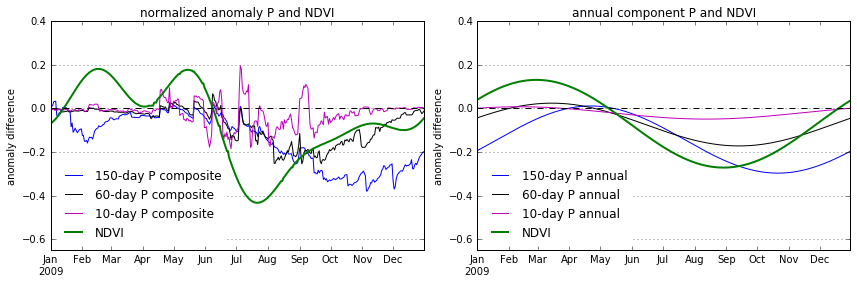

In [51]:
plt.figure(figsize=(12,4))
plt.subplot(121)
s1_150.plot(label='150-day P composite')
s1_60.plot(label='60-day P composite',color='k')
s1_10.plot(label='10-day P composite', color='m')
s2.plot(label='NDVI', linewidth=2)
from scipy import signal
b, a = signal.butter(1, 0.01)
y = signal.filtfilt(b,a,s1_10, padlen=150)
plt.plot(y)
plt.ylim([-0.65,0.4])
plt.axhline(color='k', ls='--')
leg = plt.legend(loc=3)
leg.get_frame().set_linewidth(0.0)
plt.title('normalized anomaly P and NDVI')
plt.ylabel('anomaly difference')
plt.tight_layout()
plt.grid(axis='y')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
out_pth = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\png//prec_ndvi_all.png'
#savefig(out_pth, dpi=200)
print out_pth

plt.subplot(122)
ts1_150.plot(label='150-day P annual')
ts1_60.plot(label='60-day P annual',color='k')
ts1_10.plot(label='10-day P annual', color='m')
ts2.plot(label='NDVI', linewidth=2)
from scipy import signal
b, a = signal.butter(1, 0.01)
y = signal.filtfilt(b,a,s1_10, padlen=150)
plt.plot(y)
plt.ylim([-0.65,0.4])
plt.axhline(color='k', ls='--')
leg = plt.legend(loc=3)
leg.get_frame().set_linewidth(0.0)
plt.title('annual component P and NDVI')
plt.ylabel('anomaly difference')
plt.tight_layout()
plt.grid(axis='y')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
out_pth = r'D:\Downloads\Libraries_documents\HOME\Figures paper//prec_ndvi_raw_annuall.png'
plt.savefig(out_pth, dpi=200)
print out_pth
plt.show()

In [16]:
tile_no = 50
x_10, y_10, t = pad_extend(s1_10, s2, tile_no=tile_no, extend = 0)
f_10, fkx, fky, cxy_10, ph_10, coh_10 = mtem(x_10,y_10)
phif_10 = mtem_unct(x_10,y_10,coh_10, mc_no=5)

tile_no = 50
x_60, y_60, t = pad_extend(s1_60, s2, tile_no=tile_no, extend = 0)
f_60, fkx, fky, cxy_60, ph_60, coh_60 = mtem(x_60,y_60)
phif_60 = mtem_unct(x_60,y_60,coh_60, mc_no=5)

tile_no = 50
x_150, y_150, t = pad_extend(s1_150, s2, tile_no=tile_no, extend = 0)
f_150, fkx, fky, cxy_150, ph_150, coh_150 = mtem(x_150,y_150)
phif_150 = mtem_unct(x_150,y_150,coh_150, mc_no=5)

('x size', (18614,))
('y size', (18614,))
('iteration no is', 5)
('x size', (18614,))
('y size', (18614,))
('iteration no is', 5)
('x size', (18614,))
('y size', (18614,))
('iteration no is', 5)


('phase in radian is', 0.29)
('which correspond to', 16.61, 'day')


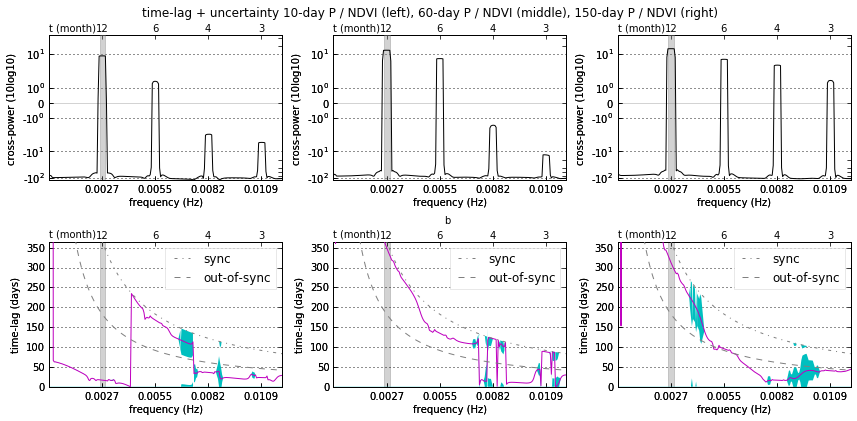

In [76]:
## PLOT 9
rad2time = ph_10/(2*np.pi*f_10)
mtcl2time = phif_10/(2*np.pi*f_10)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_10)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

#frequency index
f_lb = vspan_start 
f_ub = vspan_end
f_ix = np.where((f_10 > f_lb) * (f_10 < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph_10[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')

plt.figure(figsize=(12,5.7))
plt.suptitle('CSD 10-day P / NDVI (left), 60-day P / NDVI (middle), 150-day P / NDVI (right)', 
            y = 1.015, fontsize=12)
plt.suptitle('time-lag + uncertainty 10-day P / NDVI (left), 60-day P / NDVI (middle), 150-day P / NDVI (right)',
              y = 1.015, fontsize=12)
# plot 1
ax = host_subplot(231, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([-120,50])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.axhline(zorder=2, color='lightgray')#, alpha=1)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=19)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('CSD 10-day P / NDVI', fontsize=30)
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

ax.grid(axis='y', zorder =1)
ax.plot(f_10,10*np.log10(cxy_10), 'k',zorder=5)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder =3)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
ax.set_yscale('symlog')

# plot 2
ax = host_subplot(232, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([-120,50])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.axhline(zorder=2, color='lightgray')#, alpha=1)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=19)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.setxlabel('CSD (c) 10-day P / NDVI, (d) 60-day P / NDVI, (e) 150-day P / NDVI', fontsize=30)
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

ax.grid(axis='y', zorder =1)
ax.plot(f_60,10*np.log10(cxy_60), 'k',zorder=5)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder =3)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
ax.set_yscale('symlog')

# plot 3
ax = host_subplot(233, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([-120,50])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.axhline(zorder=2, color='lightgray')#, alpha=1)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('CSD 150-day P / NDVI', fontsize=30)
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

ax.grid(axis='y', zorder =1)
ax.plot(f_150,10*np.log10(cxy_150), 'k',zorder=5)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder =3)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
ax.set_yscale('symlog')

# plot 4
ax = host_subplot(234, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_10, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_10, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_10, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_10,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time-lag (days)')
ax.set_title('t (month)', loc='left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=19)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder=-1)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

lg = plt.legend([p3,p4], ['sync','out-of-sync'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

# plot 5
ax = host_subplot(235, axes_class=AA.Axes)

rad2time = ph_60/(2*np.pi*f_60)
mtcl2time = phif_60/(2*np.pi*f_60)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_60)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_60, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_60, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_60, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_60,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time-lag (days)')
ax.set_title('t (month)', loc='left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=19)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder=-1)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#plt.suptitle('x')
ax2.set_xlabel('b ')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

lg = plt.legend([p3,p4], ['sync','out-of-sync'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

# plot 6
ax = host_subplot(236, axes_class=AA.Axes)

rad2time = ph_150/(2*np.pi*f_150)
mtcl2time = phif_150/(2*np.pi*f_150)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_150)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_150, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_150, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_150, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_150,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time-lag (days)')
ax.set_title('t (month)', loc='left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=19)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder=-1)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

lg = plt.legend([p3,p4], ['sync','out-of-sync'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

#plt.gcf().tight_layout()
plt.tight_layout()

out_pth = r'D:\Downloads\Libraries_documents\HOME\Figures paper//prec_ndvi_cross-power_2ndtitle.png'
plt.savefig(out_pth, dpi=400, bbox_inches='tight')

('phase in radian is', 0.29)
('which correspond to', 16.61, 'day')
('phase in radian is', 0.29)
('which correspond to', 350.16, 'day')
('phase in radian is', 0.29)
('which correspond to', 312.14, 'day')


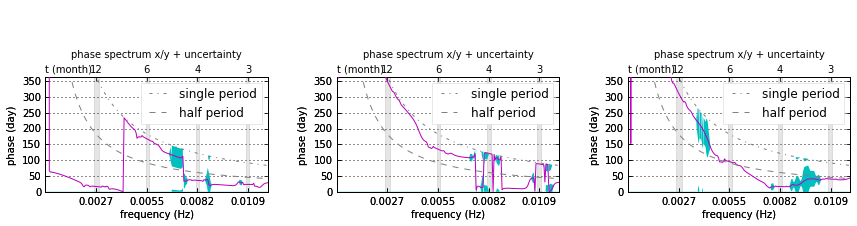

In [23]:
plt.figure(figsize=(12,3))
## PLOT 9
rad2time = ph_10/(2*np.pi*f_10)
mtcl2time = phif_10/(2*np.pi*f_10)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_10)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

#frequency index
f_lb = vspan_start 
f_ub = vspan_end
f_ix = np.where((f_10 > f_lb) * (f_10 < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph_10[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')


ax = host_subplot(131, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_10, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_10, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_10, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_10,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_10,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['single period','half period'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)

# frequency index
#f_lb = 0.0054 # vspan_start 
#f_ub = 0.0056 # vspan_end
#f_ix = np.where((f > f_lb) * (f < f_ub))[0]
#p_r2t = np.mean(rad2time[f_ix], -1)
#p_ph = np.mean(ph[f_ix], -1)
#print ('phase in radian is', round(p_ph,2))
#print ('which correspond to', round(p_r2t,2), 'day')
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)

## PLOT 9
rad2time = ph_60/(2*np.pi*f_60)
mtcl2time = phif_60/(2*np.pi*f_60)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_60)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

#frequency index
f_lb = vspan_start 
f_ub = vspan_end
f_ix = np.where((f_10 > f_lb) * (f_10 < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph_10[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')


ax = host_subplot(132, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_60, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_60, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_60, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_60,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_60,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['single period','half period'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)

# frequency index
#f_lb = 0.0054 # vspan_start 
#f_ub = 0.0056 # vspan_end
#f_ix = np.where((f > f_lb) * (f < f_ub))[0]
#p_r2t = np.mean(rad2time[f_ix], -1)
#p_ph = np.mean(ph[f_ix], -1)
#print ('phase in radian is', round(p_ph,2))
#print ('which correspond to', round(p_r2t,2), 'day')
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)

## PLOT 9
rad2time = ph_150/(2*np.pi*f_150)
mtcl2time = phif_150/(2*np.pi*f_150)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f_150)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

#frequency index
f_lb = vspan_start 
f_ub = vspan_end
f_ix = np.where((f_10 > f_lb) * (f_10 < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph_10[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')


ax = host_subplot(133, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f_150, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f_150, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f_150, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f_150,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f_150,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['single period','half period'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)

# frequency index
#f_lb = 0.0054 # vspan_start 
#f_ub = 0.0056 # vspan_end
#f_ix = np.where((f > f_lb) * (f < f_ub))[0]
#p_r2t = np.mean(rad2time[f_ix], -1)
#p_ph = np.mean(ph[f_ix], -1)
#print ('phase in radian is', round(p_ph,2))
#print ('which correspond to', round(p_r2t,2), 'day')
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)


plt.show()

In [13]:
#frequency index
f_lb = vspan_start 
f_ub = vspan_end
f_ix = np.where((f_10 > f_lb) * (f_10 < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph_10[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')


('phase in radian is', 0.29)
('which correspond to', 312.14, 'day')
